***
# Final Project Computational Tools for Data Science 2023

**Link to assignment description:** https://courses.compute.dtu.dk/02807/2023/project/project.pdf
***

## Table of Contents
* [0. Requirements](#binning)
* [1. Data](#data)
* [2. Topic Modelling](#topicmodelling)
* [3. Sentiment Analysis](#sentiment)
* [3. Network](#network)
* [4. Subject Matter Experts](#sme)
* [5. References](#references)

## 0. Requirements <a class="anchor" id="requirements"></a>

In [ ]:
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim.corpora as corpora
import gensim
import html
import itertools
import nltk
import numpy as np
import pandas as pd
import re
import wandb

## **Disclaimer**
Given the extensive size of our dataset, which surpasses 200GB, we recognize the difficulty for others in compiling our code, as we are unable to provide the dataset alongside our notebook and report. This notebook is intended to serve as an **illustrative guide** to our applied methodologies. We aim to be as detailed as possible to assist those who wish to replicate or adapt our methods.

## 1. Data <a class="anchor" id="data"></a>

### Parsing Data Source XML Files
The first step of preprocessing is parsing the data downloaded from the data source: https://archive.org/details/stackexchange
When downloaded and unzipped, the dataset contains 8 different xml files totalling around 60 GB. We wrote a script to parse the xml files into more interpretable csv files. This script is available upon request. The csv files take up more than 200 GB. However, the 4 files used in our project take up around 110 GB. 

### Reading the Full Dataset

In [ ]:
# Posts
chunk_size = 50000  # Example chunk size, adjust as needed
posts_chunks = []

for chunk in pd.read_csv('./output/stackoverflow/Posts.csv', chunksize=chunk_size):
    posts_chunks.append(chunk)

df_posts = pd.concat(posts_chunks)

In [ ]:
# Comments
chunk_size = 50000  # Example chunk size, adjust as needed
comments_chunks = []

for chunk in pd.read_csv('./output/stackoverflow//Comments.csv', chunksize=chunk_size):
    comments_chunks.append(chunk)

df_comments = pd.concat(comments_chunks)
df_comments.shape

In [ ]:
# Users
users_chunks = []

for chunk in pd.read_csv('./output/stackoverflow//Users.csv', chunksize=chunk_size):
    users_chunks.append(chunk)

df_users = pd.concat(users_chunks)
df_users.shape

In [ ]:
# Tags
tags_cols = ['Id', 'TagName', 'Count']

#df_tags = pd.read_csv('./output/Tags.csv', usecols=tags_cols)
tags_chunks = []

for chunk in pd.read_csv('./output/stackoverflow/Tags.csv', usecols=tags_cols, chunksize=chunk_size):
    tags_chunks.append(chunk)

df_tags = pd.concat(tags_chunks)
df_tags.shape

### Missing values

In [ ]:
if df_comments.isnull().sum().any():
    print('df_comments.isnull().sum()', '\n', df_comments.isnull().sum()[df_comments.isnull().sum() > 0], '\n', sep='')

if df_posts.isnull().sum().any():
    print('df_posts.isnull().sum()', '\n', df_posts.isnull().sum()[df_posts.isnull().sum() > 0], '\n', sep='')

if df_tags.isnull().sum().any():
    print('df_tags.isnull().sum()', '\n', df_tags.isnull().sum()[df_tags.isnull().sum() > 0], '\n', sep='')

if df_users.isnull().sum().any():
    print('df_users.isnull().sum()', '\n', df_users.isnull().sum()[df_users.isnull().sum() > 0], '\n', sep='')

In [ ]:
# df_comments
df_comments['UserId'] = df_comments['UserId'].fillna(-1)

# df_posts
df_posts = df_posts[df_posts['PostTypeId'].isin([1, 2])]

df_posts['OwnerUserId'] = df_posts['OwnerUserId'].fillna(-1)
df_posts.fillna({'ParentId': -1, 'AcceptedAnswerId': -1, 'ViewCount': -1, 'Title': 'Comment: N/A', 'Tags': 'Comment: N/A', 'AnswerCount': -1}, inplace=True)

**Trying to explain the missing values**


**`df_comments`**
- `UserId` is absent if the user has been deleted 

**`df_posts`**
- `ParentId` only present if PostTypeId = 2
- `AcceptedAnswerId` only present if PostTypeId = 1
- `ViewCount` only present if PostTypeId = 1
- `Body` not present in some PostTypeId = [4,5]. We will only look at PostTypeId = [1,2]
    - PostTypeId = 1: Question
    - PostTypeId = 2: Answer
    - PostTypeId = 4: Tag wiki excerpt
    - Check documentation
- `OwnerUserId` only present if user has not been deleted
- `Title` question title only present if PostTypeId = 1
- `Tags` question tags only present if PostTypeId = 1    
- `AnswerCount` only present if PostTypeId = 1

**How we will take action**

**`df_comments`**
- `UserId`: Before we remove comments from deleted users, we want to calculate average sentiment of threads users engage in. To calculate the average sentiment polarity of a thread, we want to include every user's comments. We therefore temporarily replace missing `UserId` with (-1).

**`df_posts`**
- We're only interested in PostTypeId 1 (Question) and 2 (Answer), so we filter out other types.
- For the below columns which are conditionally present, we fill missing values with a placeholder (-1 or 'Comment: N/A') 
    - ParentId, 
    - AcceptedAnswerId, 
    - ViewCount, 
    - Title, 
    - Tags, and 
    - AnswerCount
- For OwnerUserId, similar to the UserId in comments, we fill missing values with a placeholder (-1)

### Typecasting

In [ ]:
df_posts = df_posts.astype({
    'Id': 'int32',
    'PostTypeId': 'int32',
    'ParentId': 'int32',
    'AcceptedAnswerId': 'int16',
    'CreationDate': 'datetime64[ns]',
    'Score': 'int16',
    'ViewCount': 'int32',
    'Body': 'object',
    'OwnerUserId': 'int32',
    'LastActivityDate': 'datetime64[ns]',
    'Title': 'string',
    'Tags': 'string',
    'AnswerCount': 'int16',
    'CommentCount': 'int16'
    #'FavoriteCount': 'int16'
})

In [ ]:
df_comments = df_comments.astype({
    'Id': 'int32',
    'PostId': 'int32',
    'Score': 'int16',
    'Text': 'object',
    'CreationDate': 'datetime64[ns]',
    #'UserDisplayName': 'string',
    'UserId': 'int32'
})

In [ ]:
df_tags = df_tags.astype({
    'Id': 'int32',
    'TagName': 'string',
    'Count': 'int32'
})

In [ ]:
df_users = df_users.astype({
    'Id': 'int32',
    'Reputation': 'int32',
    'CreationDate': 'datetime64[ns]',
    'LastAccessDate': 'datetime64[ns]',
    'Views': 'int32',
    'UpVotes': 'int32',
    'DownVotes': 'int32',
})

### Data Filtering

In [ ]:
chunk_size = 50000  # This is an example size, adjust based on your system capabilities
chunks = []  # This list will store the filtered data from each chunk

# Define the regex pattern for Python tags
python_tag_pattern = re.compile(r'\b\w*python\w*\b', re.IGNORECASE)
python_file_pattern = re.compile(r'\b\.py\b', re.IGNORECASE)

for chunk in pd.read_csv('./output/stackoverflow/Posts.csv', chunksize=chunk_size):
    # Filter by tags, titles, and text using the regex patterns
    filtered_chunk = chunk[
        chunk['Tags'].str.contains(python_tag_pattern, na=False) |
        chunk['Title'].str.contains(python_tag_pattern, na=False) |
        chunk['Body'].str.contains(python_tag_pattern, na=False) |
        chunk['Title'].str.contains(python_file_pattern, na=False) |
        chunk['Body'].str.contains(python_file_pattern, na=False) 
    ]

    # Append the filtered chunk to the list
    chunks.append(filtered_chunk)

df_posts = pd.concat(chunks)

# Create a Set of Relevant User IDs 
unique_user_ids = set(df_posts['OwnerUserId'].unique())

In [ ]:
# Filter Other CSV Files While Reading them

# Comments
chunk_size = 50000  # Example chunk size, adjust as needed
filtered_comments_chunks = []

for chunk in pd.read_csv('./output/stackoverflow//Comments.csv', chunksize=chunk_size):
    filtered_chunk = chunk[chunk['UserId'].isin(unique_user_ids)]
    filtered_comments_chunks.append(filtered_chunk)

df_comments = pd.concat(filtered_comments_chunks)

In [ ]:
# Users
user_cols = ['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'Views', 'UpVotes', 'DownVotes']

filtered_users_chunks = []

for chunk in pd.read_csv('./output/stackoverflow//Users.csv', chunksize=chunk_size, usecols=user_cols):
    filtered_chunk = chunk[chunk['Id'].isin(unique_user_ids)]
    filtered_users_chunks.append(filtered_chunk)

df_users = pd.concat(filtered_users_chunks)

In [ ]:
# Tags
tags_cols = ['Id', 'TagName', 'Count']

tags_chunks = []

for chunk in pd.read_csv('./output/stackoverflow/Tags.csv', chunksize=chunk_size, usecols=tags_cols):
    tags_chunks.append(chunk)

df_tags = pd.concat(tags_chunks)

### Filtering Active Users (>= 50 posts + comments)

In [ ]:
# Remove entries with -1 in UserId and OwnerUserId columns
df_comments = df_comments[df_comments['UserId'] != -1]
df_posts = df_posts[df_posts['OwnerUserId'] != -1]

# Selecting only questions from posts
questions_df = df_posts[df_posts['PostTypeId'] == 1]
answers_df = df_posts[df_posts['PostTypeId'] == 2]

# Count unique users involved in questions and comments
unique_user_count = len(pd.concat([questions_df["OwnerUserId"], answers_df["OwnerUserId"], df_comments["UserId"]]).unique())

# Calculate post and comment counts for each user
user_posts_count = df_posts.groupby('OwnerUserId').size().rename('PostCount')
user_comments_count = df_comments.groupby('UserId').size().rename('CommentCount')

# Merge counts with user data and fill missing values with 0
user_data = df_users.merge(user_posts_count, left_on='Id', right_index=True, how='left')
user_data = user_data.merge(user_comments_count, left_on='Id', right_index=True, how='left')
user_data.fillna({'PostCount': 0, 'CommentCount': 0}, inplace=True)

# Add a column for total activity and filter for active users
user_data['TotalActivity'] = user_data['PostCount'] + user_data['CommentCount']

# Get sets of active user IDs after Activity Threshold
active_users = user_data[user_data['TotalActivity'] > 50]
active_user_ids = set(active_users['Id'])

# Filter questions and comments for active user activity
filtered_questions_df = questions_df[questions_df['OwnerUserId'].isin(active_user_ids)]
active_user_post_ids = set(df_posts[df_posts['OwnerUserId'].isin(active_user_ids)]['Id'])
filtered_comments = df_comments[(df_comments['UserId'].isin(active_user_ids)) | 
                                (df_comments['PostId'].isin(active_user_post_ids))].drop_duplicates()

# Count unique users in filtered questions and comments
unique_active_user_count = len(pd.concat([filtered_questions_df["OwnerUserId"], filtered_comments["UserId"]]).unique())

### Preprocessing text

In [ ]:
# Modify preprocess_text function
def preprocess_text(text, remove_stopwords=False, use_lemmatize=True):
    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

    words = text.split()
    if remove_stopwords:
        words = [word for word in words if word not in stopwords.words('english')]
    if use_lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)
    
    return text

## 2. Topic Modelling <a class="anchor" id="topicmodelling"></a>
In this section, we will quickly demonstrate how we applied TF-IDF, LDA and NMF. We say quickly, as we didn't end up using the results in the report. Afterwards, we go more into depth with how we applies the A-Priori algorithm.

### Data preparation

In [ ]:
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from collections import Counter
import os

In [ ]:
directory = './picklefiles'
file_pattern = 'posts_typecasted_'
# List all files that start with the specified pattern
matching_files = [file for file in os.listdir(directory) if file.startswith(file_pattern)]
matching_files

['posts_typecasted_1.pkl',
 'posts_typecasted_2.pkl',
 'posts_typecasted_3.pkl',
 'posts_typecasted_4.pkl']

In [ ]:
df_posts = []
for file in matching_files:
    df_posts.append(pd.read_pickle(os.path.join(directory,file)))

df_posts = pd.concat(df_posts)

In [ ]:
df_posts = df_posts[df_posts['ParentId'] == -1]
def prune_python_tag(tag):
    return tag.replace('<python>', '')
df_posts['Tags'] = list(map(prune_python_tag, df_posts['Tags']))

def split_tags(tags):
    return tuple([el.replace('<','').replace('>','') for el in tags.split('><')])
df_posts['Tags'] = list(map(split_tags, df_posts['Tags']))

TAGS = df_posts['Tags']

### TF-IDF, LDA & NMF

In [ ]:
# WandB Login
wandb.login()

# Define apply_lda_and_log function with run_name parameter
def apply_topic_modeling_and_log(df, remove_stopwords, use_lemmatize, tags_weighting, run_name, ngram_range=(1, 1), max_features=2000):
    # Start a new WandB run with the specified name
    wandb.init(project="stackoverflow", entity="sxxxxxx", name=run_name)

    # Initialize dictionaries to store topic distributions
    lda_distributions = {}
    nmf_distributions = {}

    # Preprocess Title, Body, and Tags
    df['Title'] = df['Title'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize ))
    df['Body'] = df['Body'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize ))
    df['Tags'] = df['Tags'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))


    # Combine Title, Body, and Tags with specified weight for Tags
    # We Keep the original order (title, body, tags) as it reflects the natural flow of information
    df['CombinedText'] = df['Title'] + ' ' + df['Body'] + ' ' + (df['Tags'] * tags_weighting)

    # Create a Dictionary and Corpus needed for Topic Modeling
    words = [doc.split() for doc in df['CombinedText']]
    id2word = corpora.Dictionary(words)
    corpus = [id2word.doc2bow(text) for text in words]

    # Apply TF-IDF with the specified max_features
    # ngram_range=(1, 2) for bi-grams, (1, 3) for tri-grams, and (2, 2) for only bi-grams
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['CombinedText'])

    # Apply LDA and NMF for different numbers of topics
    # Prepare a structured dictionary to store results with n_topics as part of the key
    all_topics_results = {}
    for n_topics in [5, 10, 15, 20]:
        
        # LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
        lda.fit(tfidf_matrix)

        # Extract Topic Distributions for LDA
        lda_topic_distributions = lda.transform(tfidf_matrix)

        # Normalize LDA Topic Distributions
        lda_normalized = np.array(lda_topic_distributions) / np.sum(lda_topic_distributions, axis=1)[:, None]

        # Calculate Coherence Score
        lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=0)
        coherence_model_lda = CoherenceModel(model=lda_gensim, texts=words, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        # Calculate LDA Perplexity
        lda_perplexity = lda.perplexity(tfidf_matrix)

        # Log Coherence and Perplexity Score
        wandb.log({"coherence_score": coherence_lda, "perplexity_score": lda.perplexity(tfidf_matrix)})
        
        # Extract and log the top words for each topic as a table
        feature_names = tfidf_vectorizer.get_feature_names_out()
        top_words_data = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            top_words_data.append([f"Topic {topic_idx}"] + top_words)

        # Create a WandB Table with top words data
        columns = ["Topic"] + [f"Word {i+1}" for i in range(10)]
        top_words_table = wandb.Table(data=top_words_data, columns=columns)
        
        # Log the table to WandB
        wandb.log({f"n_topics_{n_topics}_cleaned_{str(remove_stopwords)}_lemmatize_{str(use_lemmatize)}_weight_{tags_weighting}": top_words_table})

        # NMF
        nmf_model = NMF(n_components=n_topics, random_state=0)
        nmf_W = nmf_model.fit_transform(tfidf_matrix)

        # Normalize NMF Topic Distributions (nmf_W is already the topic distribution matrix)
        nmf_normalized = np.array(nmf_W) / np.sum(nmf_W, axis=1)[:, None]

        nmf_H = nmf_model.components_

        # Calculate NMF Reconstruction Error
        nmf_reconstruction_error = np.linalg.norm(tfidf_matrix - nmf_W.dot(nmf_H))

        # Log the top words for each topic for NMF
        nmf_top_words_data = []
        for topic_idx, topic in enumerate(nmf_H):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            nmf_top_words_data.append([f"Topic {topic_idx}"] + top_words)

        nmf_top_words_table = wandb.Table(data=nmf_top_words_data, columns=columns)
        wandb.log({f"nmf_n_topics_{n_topics}": nmf_top_words_table})

        # Store the results including perplexity and reconstruction error
        all_topics_results[f"{run_name}_n_topics_{n_topics}"] = {
            'lda_normalized': lda_normalized,
            'nmf_normalized': nmf_normalized,
            'lda_coherence': coherence_lda,
            'lda_perplexity': lda_perplexity,
            'nmf_reconstruction_error': nmf_reconstruction_error,
            'lda_top_words': top_words_data,
            'nmf_top_words': nmf_top_words_data
        }
        
    # Close WandB run
    wandb.finish()

    # Return the topic distributions
    return all_topics_results

### Running different LDA and NMF configurations

In [ ]:
# Define your parameter ranges
remove_stopwords = True
use_lemmatize_options = [False, True]
tags_weighting_options = [1, 2, 5]
ngram_range_options = [(1, 1), (1, 2), (1, 3)]

# Store the results for each n_topics uniquely
all_results = {}

# Store the results for each n_topics uniquely
all_results = {}

# Iterate over the combinations of other options
for use_lemmatize, tags_weighting, ngram_range in itertools.product(use_lemmatize_options, tags_weighting_options, ngram_range_options):
    # Convert ngram_range tuple to string format
    ngram_range_str = '_'.join(map(str, ngram_range))

    # Construct a unique run name for this combination
    run_name = f"Run_remove_{remove_stopwords}_lemmatize_{use_lemmatize}_weight_{tags_weighting}_ngram_{ngram_range_str}_maxfeat_2000"

    # Run the function and get the results
    topics_results = apply_topic_modeling_and_log(
        questions_df, 
        remove_stopwords, 
        use_lemmatize, 
        tags_weighting, 
        run_name, 
        ngram_range, 
        max_features=2000
    )

    # Update all_results to include these structured results
    all_results.update(topics_results)

### A-Priori

In [ ]:
def plot_items(item_counts, percentage = False, percentile = 50, top = 30, figsize=(10,6)):
    if percentage:
        item_counts_perc = dict()
        total_items = sum(item_counts.values())
        for (it, count) in item_counts.items():
            item_counts_perc[it] = 100*count / total_items
        item_counts = item_counts_perc
    item_counts_top = dict(sorted(item_counts.items(), key=lambda item: item[1], reverse=True)[:top])
    # Creating a horizontal bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(list(item_counts_top.keys()), list(item_counts_top.values()), color='skyblue')
    plt.xlabel('% (Count/Total) ')
    plt.ylabel('Items')
    plt.title('Count of Different Appearances of Items')
    plt.show()


In [ ]:
from efficient_apriori import apriori
itemsets, rules = apriori(TAGS, min_support=0.0001, min_confidence=0.2)

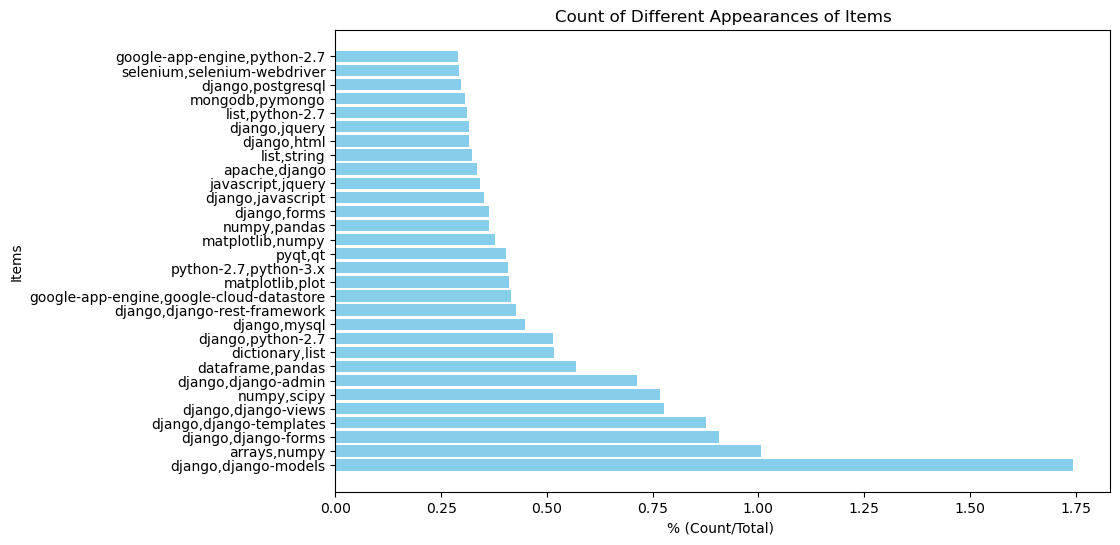

In [ ]:
itemsets[2]
itemsets_clean = dict()
for n in itemsets.keys():
    itemsets_clean[n] = dict()
    for (key, value) in itemsets[n].items():
        itemsets_clean[n][','.join(list(key))] = value
plot_items(itemsets_clean[2], percentage=True, percentile=50, top = 30)

### Network Methods

In [ ]:
import random

def select_random_nodes(G, size, seed = 42):
    # Selecting a random number of nodes from the graph
    num_nodes_to_select = size
    random.seed(seed)
    selected_nodes = random.sample(sorted(dict(G.nodes())), num_nodes_to_select)

    # Creating a subgraph with the selected nodes
    return G.subgraph(selected_nodes)

In [ ]:
from collections import Counter
# Counting occurrences of each item in the tuples
tag_counts = Counter([item for sublist in TAGS for item in sublist])

In [ ]:
import networkx as nx
# Creating a graph
G = nx.Graph()

# Adding nodes and edges based on the tuples
for id, items in TAGS.items():
    for i in range(len(items)):
        if not G.has_node(items[i]):
            G.add_node(items[i], counts=tag_counts[items[i]])  # Add each item as a node
        for j in range(i + 1, len(items)):
            # Check if the edge already exists
            if G.has_edge(items[i], items[j]):
                # Increase weight by 1 if the edge exists
                G[items[i]][items[j]]['weight'] += 1
            else:
                # Add edge with initial weight 1 if it doesn't exist
                G.add_edge(items[i], items[j], weight=1)

#### Basic info

In [ ]:
def degree_distribution_plot(d1, label1, d2, label2, title="", n_bins = 100, cut = 10, figsize = (15,7), fig = None, ax = None):
    # Convert input lists to Python lists
    d1 = list(d1)
    if(d2 != None ):
        d2 = list(d2)

    # Create bins for the histogram using numpy's linspace function
    # The bins range from the minimum to the maximum of the combined d1 and d2 lists
    if(d2 != None ):
        bins = np.linspace(min(d1+d2), max(d1+d2), n_bins)
    else:
        bins = np.linspace(min(d1), max(d1), n_bins)
    
    # Use numpy's histogram function to calculate the frequency and bin edges for d1 and d2
    frq1, edges1 = np.histogram(a=d1, bins=bins)
    if(d2 != None ):
        frq2, edges2 = np.histogram(a=d2, bins=bins)

    # If no figure or axis is provided, create a new one
    if(fig == None and ax == None):
        fig, ax = plt.subplots(1, 1)

    # If a title is provided, set it as the figure's title
    if(title != ""):
        fig.suptitle(title, fontsize=16)

    # Set the figure's height and width
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    # Plot the histogram for d1 and d2
    ax.hist(edges1[:-1], n_bins, weights=frq1, label=label1, alpha = 0.7)
    if(d2 != None ):
        ax.hist(edges2[:-1], n_bins, weights=frq2, label=label2, alpha = 0.7)

    d1_scatter = [d for d in d1 if d > cut]
    ax.scatter(d1_scatter, [0.5]*len(d1_scatter), marker='+', color='tab:blue', alpha=0.7)

    if d2 != None:
        d2_scatter = [d for d in d2 if d > cut]
        ax.scatter(d2_scatter, [0.5]*len(d2_scatter), marker='x', color='tab:orange', alpha=0.7)

    
    # Set labels for the x and y axes
    ax.set_xlabel("k")
    ax.set_ylabel("count")

    # Add a legend to the plot
    ax.legend()

    # Hide the bottom spine of the plot
    ax.spines['bottom'].set_visible(False)

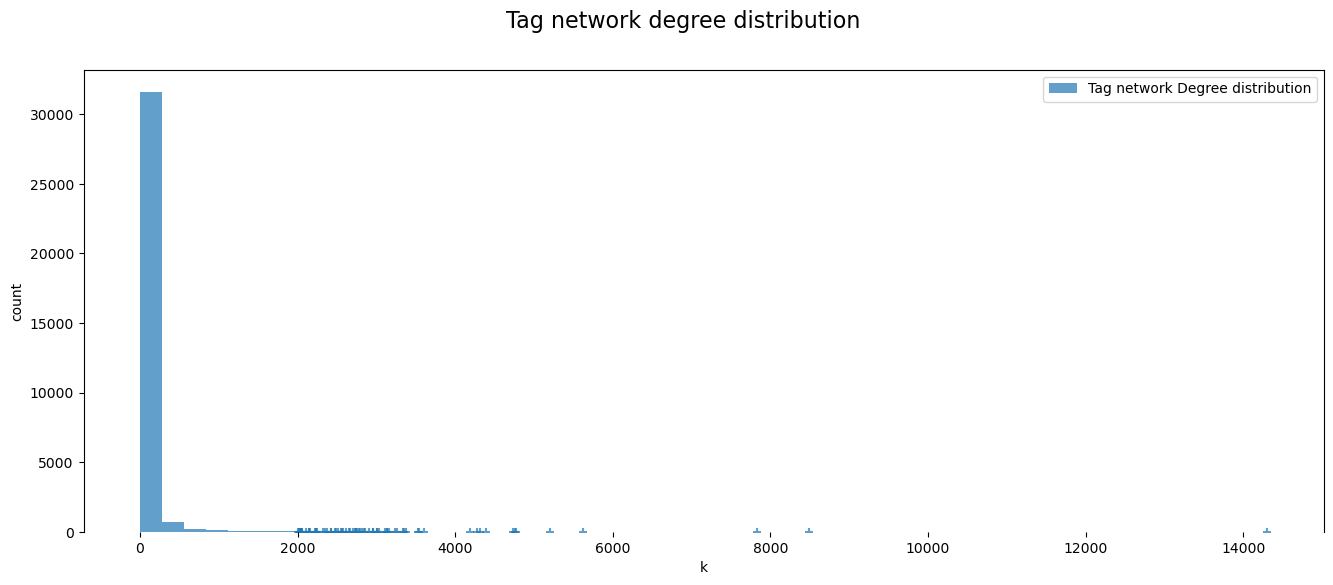

In [ ]:
# Compare each plot
degree_distribution_plot(dict(G.degree).values(), "Tag network Degree distribution", 
    None, "",title='Tag network degree distribution', cut = 2000, n_bins=50, figsize=(16,6))

In [ ]:
for i in range(10):
    print(f"Degree {i}: {sum(pd.Series(list(dict(G.degree()).values())) == i)}")

Degree 0: 0
Degree 1: 1437
Degree 2: 2652
Degree 3: 3513
Degree 4: 2777
Degree 5: 1591
Degree 6: 1477
Degree 7: 1239
Degree 8: 1017
Degree 9: 932


In [ ]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 32822
Number of edges: 880862


In [ ]:
n_comp = [len(el) for el in nx.connected_components(G)]
n_comp = sorted(n_comp, reverse=True)

In [ ]:
np.average(n_comp)*1775

3236613.8888888885

In [ ]:
nx.number_connected_components(G)

18

#### Spectral clustering

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import matplotlib.cm as cm

# graph = select_random_nodes(G, 2000, seed=42)
graph = final_graph.subgraph(max(nx.connected_components(final_graph), key=len))
# Convert the graph into an adjacency matrix
adj_matrix = nx.to_numpy_array(graph)
print("Spectral clustering starting...")
# Apply spectral clustering
sc = SpectralClustering(8, affinity='precomputed', n_init=100, assign_labels='kmeans')
sc.fit(adj_matrix)
print("Spectral clustering finished.")
# Assigning a color to each community for visualization
labels = sc.labels_

Spectral clustering starting...


Spectral clustering finished.


In [ ]:
Counter(labels)

Counter({0: 32760, 6: 3, 2: 2, 5: 3, 4: 2, 1: 2, 7: 3, 3: 2})

In [ ]:
community_colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

graph_selection = select_random_nodes(graph, 2000, seed=42)

# Create a dictionary to assign a color to each node based on its community
node_colors = {node: community_colors[labels[i]] for i, node in enumerate(graph_selection.nodes())}

pos = nx.kamada_kawai_layout(graph_selection) # or use other layout algorithms like nx.kamada_kawai_layout

Plotting starting...


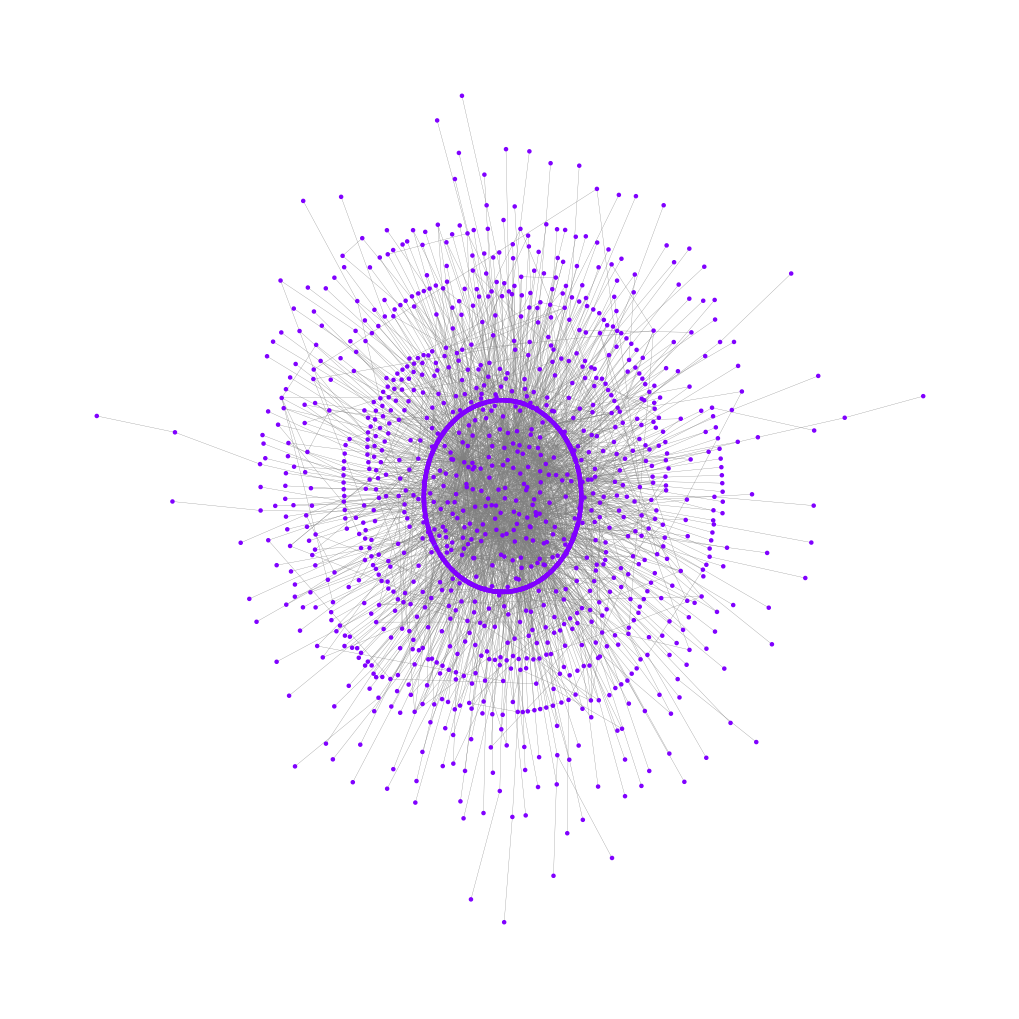

In [ ]:
# Visualize the graph with community colors
plt.figure(figsize=(10, 10))
print("Plotting starting...")
nx.draw(graph_selection, pos, node_color=[node_colors[node] for node in graph_selection.nodes()], 
        edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
plt.show()

#### Louvain

In [ ]:
def process_communities(in_communities):
    out = []
    for comm in in_communities:
        l = set()
        for tag in comm:
            l.add((tag, tag_counts[tag]))
        out += [l]
    out = sorted(out, key=lambda l: sum([count for (_,count) in l]), reverse=True)
    out = [sorted(comm, key=lambda item: item[1], reverse=True) for comm in out ]
    return out


In [ ]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# graph = select_random_nodes(G, 2000, seed=42)
graph = G.subgraph(max(nx.connected_components(G), key=len))
# graph = select_random_nodes(graph, 2000, seed=42)

df = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities"])

for i in range(20):
    # Apply the Louvain community detection algorithm
    resolution = 0.5 + i/10
    communities = louvain_communities(graph, seed = 1234, resolution=resolution)
    df.loc[len(df)] = {
        "Resolution": resolution,
        "# Communities": len(communities),
        "# Significant Communities": len([len(comm) for comm in communities if len(comm) > 400]),
        "Communities": communities
    }

In [ ]:
df

,Resolution,# Communities,# Significant Communities,Communities
0,0.5,12,4,"[{picosat, web3js, trx, go-ethereum, thegraph,..."
1,0.6,12,5,"[{go-sqlite3, stocator, ddd-service, phpass, x..."
2,0.7,11,5,"[{linq-to-entities, qlcdnumber, edaplayground,..."
3,0.8,10,6,"[{implementation, evidently, varcharmax, telec..."
4,0.9,13,9,"[{go-sqlite3, messagebroker, user-identificati..."
5,1.0,15,10,"[{go-sqlite3, messagebroker, user-identificati..."
6,1.1,16,11,"[{go-sqlite3, messagebroker, user-identificati..."
7,1.2,15,12,"[{go-sqlite3, messagebroker, user-identificati..."
8,1.3,18,14,"[{implementation, hamiltonian-cycle, minesweep..."
9,1.4,19,15,"[{prometheus-java, promtail, prometheus-node-e..."


In [ ]:
communities = list(df["Communities"][df["Resolution"] == 1.0])[0]

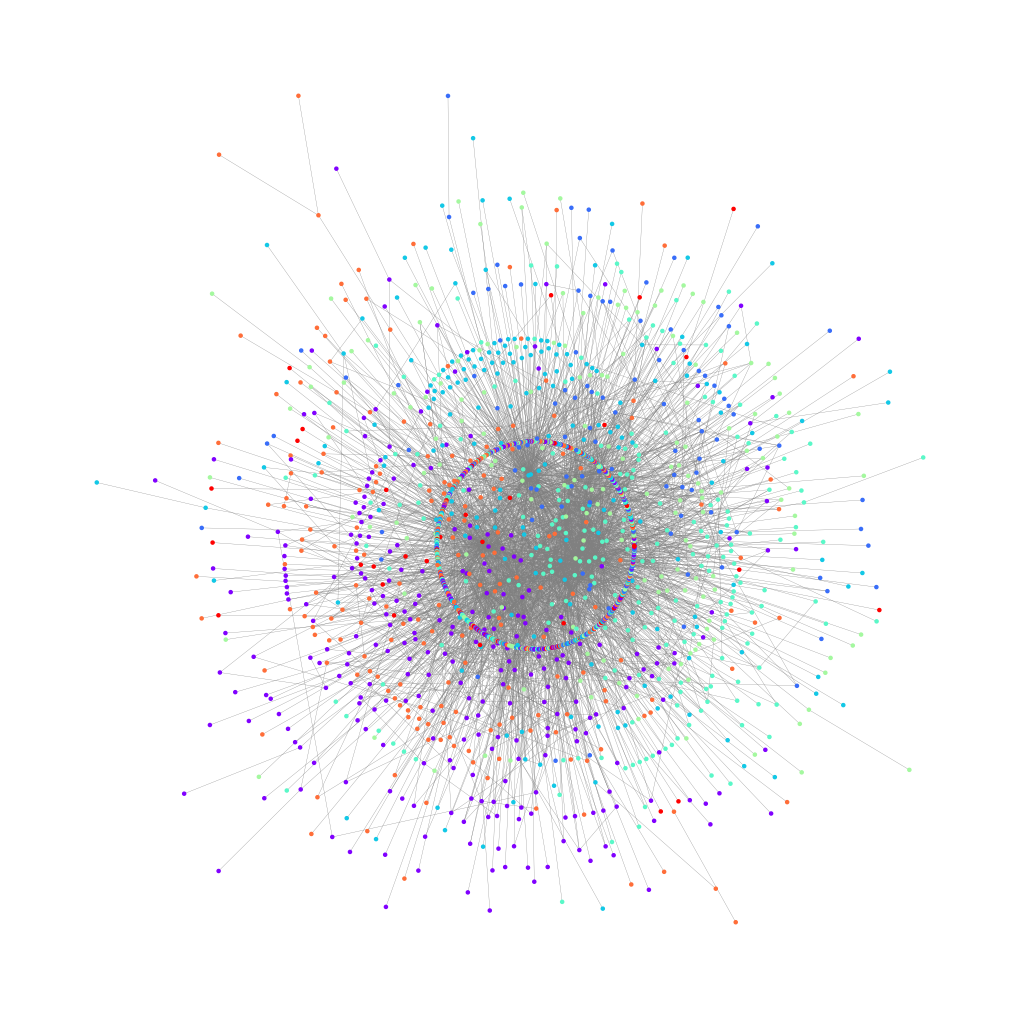

In [ ]:
# Assigning a color to each community for visualization
community_colors = cm.rainbow(np.linspace(0, 1, len(communities)))

# Create a dictionary to assign a color to each node based on its community
node_colors = {}
for community_index, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_colors[node] = community_colors[community_index]


# Visualize the graph with community colors
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(graph)  # or use other layout algorithms like nx.kamada_kawai_layout
nx.draw(graph, pos, node_color=[node_colors[node] for node in graph.nodes()], 
        edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
plt.show()

In [ ]:
sorted_communities = process_communities(communities)

In [ ]:
[len(comm) for comm in sorted_communities]

[4712, 5959, 9885, 2672, 2604, 2098, 1919, 744, 953, 813, 184, 212, 13, 12, 8]

##### Divide subcommunities (only if we have communities that are too large)

In [ ]:
too_large_community = -1

In [ ]:
if too_large_community >= 0:
    first_community = graph.subgraph([node for (node,_) in sorted_communities[too_large_community]])
    df_subcommunity = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities"])

    for i in range(20):
        # Apply the Louvain community detection algorithm
        resolution = 0.5 + i/10
        subcommunities = louvain_communities(first_community, seed = 1234, resolution=resolution)
        df_subcommunity.loc[len(df_subcommunity)] = {
            "Resolution": resolution,
            "# Communities": len(subcommunities),
            "# Significant Communities": len([len(comm) for comm in subcommunities if len(comm) > 400]),
            "Communities": subcommunities
        }
    sorted_subcommunities = process_communities(df_subcommunity.loc[0]["Communities"])
    print("Subcommunity partition:")
    print([len(comm) for comm in sorted_subcommunities])
    sorted_communities = sorted_communities[:too_large_community] + sorted_subcommunities + sorted_communities[too_large_community:]

In [ ]:
sorted_communities = pickle.load(open('./picklefiles/communities_louvain.pkl', 'rb'))

##### Result

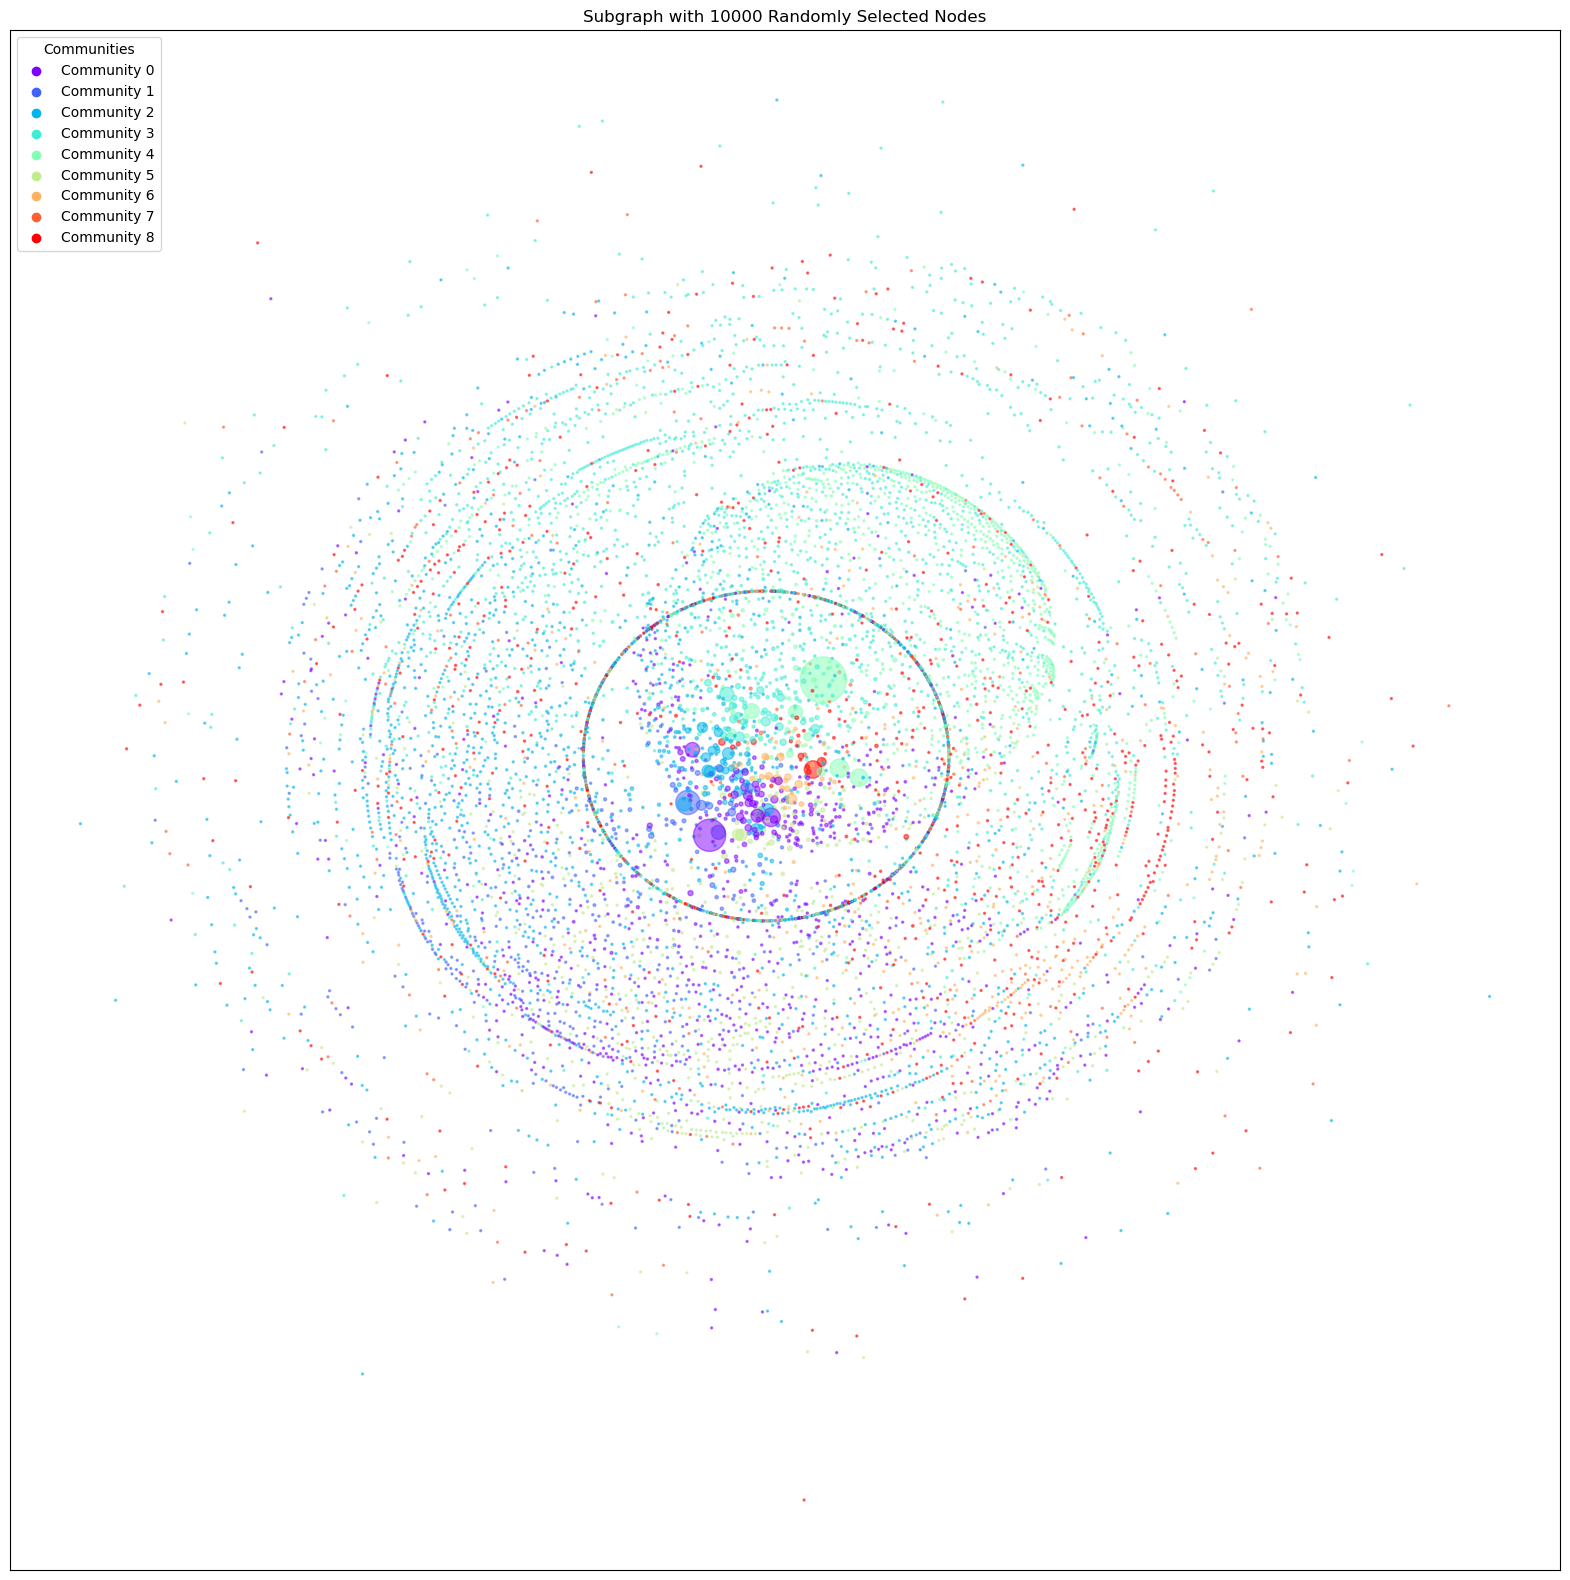

In [ ]:
import networkx as nx
num_nodes_to_select = 10000

final_graph = graph.subgraph([node for comm in sorted_communities for (node,_) in comm])
graph_to_plot =  select_random_nodes(final_graph, num_nodes_to_select, seed=42)

bigger_nodes = [node for node in graph_to_plot.nodes() if tag_counts[node] > 500]
labels = {node: node for node in bigger_nodes}

# Adjusting the node size based on the degree (e.g., degree * 1000 for visibility)
node_sizes = [tag_counts[node] * 0.1 + 5 for node in graph_to_plot.nodes()]

# Assigning a color to each community for visualization
community_colors = cm.rainbow(np.linspace(0, 1, len(sorted_communities)))

# Creating a dictionary for node colors
node_colors = {}

for community_index, community_nodes in enumerate(sorted_communities):
    for node,_ in community_nodes:
        # Assigning the color to the node in the dictionary
        node_colors[node] = community_colors[community_index]

# # Drawing the subgraph

pos = nx.kamada_kawai_layout(graph_to_plot)

node_sizes = [tag_counts[node] * 0.005 + 2 for node in graph_to_plot.nodes()]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(graph_to_plot, pos, node_color=[ node_colors[node] for node in graph_to_plot], node_size=node_sizes, alpha=0.5)
plt.title(f'Subgraph with {num_nodes_to_select} Randomly Selected Nodes')

# Adding a legend for community colors
for i in range(len(community_colors)):
    plt.scatter([], [], c=[community_colors[i]], label=f'Community {i}')
plt.legend(title="Communities", loc='upper left')
plt.show()

<u>**Community Analysis**</u>

**Community 1: Python Data Processing and Analysis**
- **Top 10 Tags**: python-3.x, pandas, numpy, dataframe, python-2.7, list, dictionary, regex, json, arrays
- **Total Tags in Community**: 4712
- **Total Tag Instances**: 2,156,967
- **Theme Description**: Focused on data processing and analysis in Python, with prominent data handling libraries and structures.
- **Non-Congruent High-Count Tags**: None

**Community 2: Python Web Frameworks and Technologies**
- **Top 10 Tags**: django, flask, javascript, django-models, mysql, sqlalchemy, django-rest-framework, docker, django-views, postgresql
- **Total Tags in Community**: 5959
- **Total Tag Instances**: 981,845
- **Theme Description**: Centered around Python web development, covering Django and Flask, and integrating various backend and frontend technologies.
- **Non-Congruent High-Count Tags**: None

**Community 3: Python in Diverse Operating Systems and Environments**
- **Top 10 Tags**: linux, pip, jupyter-notebook, windows, c++, pygame, multithreading, macos, java, pycharm
- **Total Tags in Community**: 9885
- **Total Tag Instances**: 973,462
- **Theme Description**: Covers Python usage in various operating systems and environments, with a focus on OS-specific questions, package management, and IDEs.
- **Non-Congruent High-Count Tags**: c++, java (indicating interdisciplinary programming)

**Community 4: Python in Machine Learning and Image Processing**
- **Top 10 Tags**: tensorflow, opencv, keras, machine-learning, scikit-learn, deep-learning, pytorch, image-processing, image, nlp
- **Total Tags in Community**: 2672
- **Total Tag Instances**: 536,960
- **Theme Description**: Revolves around machine learning and image processing, with an emphasis on frameworks like TensorFlow, Keras, and PyTorch, and topics like NLP and image processing.
- **Non-Congruent High-Count Tags**: None identified

**Community 5: Python for Data Visualization and GUI Development**
- **Top 10 Tags**: matplotlib, tkinter, pyqt, pyqt5, plot, r, user-interface, seaborn, plotly, wxpython
- **Total Tags in Community**: 2604
- **Total Tag Instances**: 429,182
- **Theme Description**: Focuses on data visualization (Matplotlib, Seaborn, Plotly) and GUI development (Tkinter, PyQt), with some overlap into the R programming language.
- **Non-Congruent High-Count Tags**: 'r' indicates some cross-language integration

**Community 6: Web Scraping and Automation with Python**
- **Top 10 Tags**: selenium, html, web-scraping, beautifulsoup, python-requests, selenium-webdriver, scrapy, xml, xpath, selenium-chromedriver
- **Total Tags in Community**: 2098
- **Total Tag Instances**: 395,626
- **Theme Description**: Dedicated to web scraping and browser automation, featuring tools like Selenium, BeautifulSoup, and Scrapy, along with web technologies like HTML and XML.
- **Non-Congruent High-Count Tags**: None identified

**Community 7: Python Scripting and System Interaction**
- **Top 10 Tags**: pyspark, amazon-web-services, apache-spark, azure, aws-lambda, amazon-s3, boto3, apache-spark-sql, amazon-ec2, elasticsearch
- **Total Tags in Community**: 1919
- **Total Tag Instances**: 190,485
- **Theme Description**: Focuses on Python scripting and interaction with system-level components, particularly in cloud services and big data processing. It includes a strong emphasis on cloud computing platforms like AWS and Azure, and big data technologies such as Apache Spark and Elasticsearch.
- **Non-Congruent High-Count Tags**: None identified

**Community 8: Python Object-Oriented Programming and Testing**
- **Top 10 Tags**: class, oop, pytest, unit-testing, inheritance, object, testing, python-sphinx, python-unittest, mocking
- **Total Tags in Community**: 744
- **Total Tag Instances**: 136,251
- **Theme Description**: Focused on object-oriented programming (OOP) in Python, covering aspects like classes, inheritance, and objects, as well as testing methodologies including unit testing and mocking.
- **Non-Congruent High-Count Tags**: None identified

**Community 9: Python and Google Cloud Services**
- **Top 10 Tags**: google-app-engine, google-cloud-platform, airflow, email, google-bigquery, google-cloud-datastore, google-cloud-storage, google-api, go, google-drive-api
- **Total Tags in Community**: 953
- **Total Tag Instances**: 109,859
- **Theme Description**: Revolves around Python's integration with Google Cloud services and platforms, including App Engine, BigQuery, and Cloud Storage, with some overlap into Google's Go language.
- **Non-Congruent High-Count Tags**: 'go' suggests some focus on Google's Go language

**Community 10: Python in Text Processing and Document Management**
- **Top 10 Tags**: unicode, pdf, encoding, utf-8, encryption, cryptography, character-encoding, ascii, python-docx, pypdf
- **Total Tags in Community**: 813
- **Total Tag Instances**: 70,346
- **Theme Description**: Concentrates on text and character encoding (Unicode, UTF-8, ASCII), document management (PDF processing with Python-docx, PyPDF), and aspects of encryption and cryptography.
- **Non-Congruent High-Count Tags**: None identified

## 3. Sentiment <a class="anchor" id="sentiment"></a>

### Sentiment Analysis

In [ ]:
# Convert comments to Dask DataFrame
ddf_comments = dd.from_pandas(filtered_comments, npartitions=8)

# Apply preprocess_text function to Text column, preprocessing the text of each comment
ddf_comments['Text_Processed'] = ddf_comments['Text'].map_partitions(lambda x: x.apply(lambda y: preprocess_text(y, remove_stopwords=True, use_lemmatize=True, use_stemmer=False)))

# Compute and convert to pandas DataFrame
df_comments_processed = ddf_comments.compute()

In [ ]:
# Initialize SentimentIntensityAnalyzer once
sia = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def analyze_sentiment(text):
    # Check if the text is missing or NaN, return 0.0 in such cases
    if pd.isna(text):
        return 0.0
    # Ensure the text is encoded as a string
    text = str(text)
    return sia.polarity_scores(text)['compound']

In [ ]:
# Convert preprocessed comments to Dask DataFrame
df_comments_dask = dd.from_pandas(df_comments_processed, npartitions=8)

# Apply sentiment analysis
df_comments_dask['Text_sentiment'] = df_comments_dask['Text'].map(analyze_sentiment)
with ProgressBar():
    df_comments_result = df_comments_dask.compute()
df_comments_result.sort_values(by='Text_sentiment', ascending=False)

[########################################] | 100% Completed | 26.71 ss


,Id,PostId,Score,Text,CreationDate,UserId,Text_Processed,Text_sentiment
24728857,36412576,23696753,0,Oh look it's finally working after 3 hours! Ev...,2014-05-16 14:05:58.440,3399642,oh look finally working 3 hour even though sti...,0.9898
80775184,122194928,69136504,0,"Wow, what an amazing explanation: very calm, c...",2021-09-10 19:45:27.787,16870652,wow amazing explanation calm clean step step e...,0.9897
6031197,8839325,7321948,0,Well I didn't want to do so because it's flame...,2011-09-07 07:54:37.877,11449,well want flamefest area let put like python p...,0.9888
82368062,124723172,70555259,1,"I do not know how to thank you to fit, when I ...",2022-01-02 12:24:51.603,15894995,know thank fit solve equation excited tear kno...,0.9876
87248722,132577995,75128782,0,"ah, it's a bit religious for such a class, but...",2023-01-15 22:53:52.893,4541045,ah bit religious class prefer prefix help clea...,0.9872
...,...,...,...,...,...,...,...,...
64307366,96320803,54118118,0,@cbasavaraj Thanks for the extra hints. I am a...,2019-02-19 16:04:08.113,5269252,cbasavaraj thanks extra hint also struggling g...,-0.9733
62431754,93414853,53264664,0,"Re, ""'blocking' just means: won't voluntarily ...",2018-11-12 15:35:20.680,801894,blocking mean voluntarily yield real python pr...,-0.9761
5538674,8136453,6792011,0,Now it gives an error in the for loop where ar...,2011-07-27 12:50:24.433,799810,give error loop argument added error state arg...,-0.9774
50002565,74289825,42487357,0,"Alas, it failed on the python setup.py step: f...",2017-04-25 20:29:04.637,4334041,ala failed python setup py step fatal error ma...,-0.9799


### Calculate average sentiment for each active user answer

In [ ]:
# Select answers from active users
active_user_answers = df_posts[(df_posts['PostTypeId'] == 2) & (df_posts['OwnerUserId'].isin(active_user_ids))]

# Calculate average sentiment for each active user answer
avg_answer_sentiment = df_comments_result.groupby('PostId')['Text_sentiment'].mean().rename('AvgAnswerSentiment')

# Merge average sentiment with active user answers and add a column for the topic of each answer
active_user_answers = active_user_answers.merge(avg_answer_sentiment, left_on='Id', right_on='PostId', how='left').fillna({'AvgAnswerSentiment': 0}) \
    .merge(df_topics, left_on='ParentId', right_on='Id', how='left').fillna({'Topic': 'None'})

In [ ]:
#Function to fill in the sentiment value of answer into corresponding topic in the topic column
def replace_sentiment(x):
    topic = x['Topic']
    if topic == 'None':
        return 0
    sentiment = x['AvgAnswerSentiment']
    return [sentiment if int(val) > 0 else 0 for val in topic]

# Apply the function to the dataframe
active_user_answers['TopicSentiment'] = active_user_answers.apply(replace_sentiment, axis=1)

### Calculate average sentiment per topic for each user

In [ ]:
def calculate_topic_sentiment(group):
    # Extract the 'TopicSentiment' column as list of lists and transpose, so each column corresponds to a topic
    transposed_topics_sentiment = group['TopicSentiment'].transpose()
    
    # Calculate the mean for each topic
    mean_values = transposed_topics_sentiment.apply(lambda x: pd.to_numeric(x, errors='coerce')).mean(axis=0)
    
    return mean_values.tolist()

In [ ]:
# Get average answer sentiment for each user
# Calculate average sentiment regardless of topic
user_avg_answer_sentiment = active_user_answers.groupby('OwnerUserId_x')['AvgAnswerSentiment'].mean().rename('AnswerSentiment')
# Remove answers without comments (no sentiment)
user_answers_drop_no_sent = active_user_answers.loc[active_user_answers['TopicSentiment'] != 0]
# Calculate average sentiment per topic for each user
user_avg_answer_sentiment_topic = active_user_answers[active_user_answers['TopicSentiment'] != 0].groupby('OwnerUserId_x').apply(calculate_topic_sentiment).rename('AvgTopicSentiment')
# merge the calculations into the active_users dataframe
active_users = active_users.merge(user_avg_answer_sentiment, left_on='Id', right_on='OwnerUserId_x', how='left').fillna({'AnswerSentiment': 0}) \
    .merge(user_avg_answer_sentiment_topic, left_on='Id', right_on='OwnerUserId_x', how='left').fillna({'AvgTopicSentiment': 0})

## 4. Network <a class="anchor" id="network"></a>

In [ ]:
def add_nodes_from_user_data(G, user_data):
    for _, row in user_data.iterrows():
        node_attributes = row.to_dict()
        user_id = node_attributes.pop('Id')
        G.add_node(user_id, **node_attributes)
        
def add_edges_from_post_data(G, posts_data):
    # Filter to only answers and drop NaNs
    answers_data = posts_data[posts_data['PostTypeId'] == 2].dropna(subset=['ParentId', 'OwnerUserId'])

    # Create a lookup table for question askers
    question_askers = posts_data[posts_data['PostTypeId'] == 1].set_index('Id')['OwnerUserId']

    # Iterate through answers
    for answerer_id, question_id in zip(answers_data['OwnerUserId'], answers_data['ParentId']):
        asker_id = question_askers.get(question_id)
        # Check that answerer and asker are not the same
        if asker_id is not None and answerer_id != asker_id:
            G.add_edge(answerer_id, asker_id)

def add_edges_from_comment_data(G, comments_data, posts_data):
    # Drop NaNs
    comments_data = comments_data.dropna(subset=['PostId', 'UserId'])

    # Create a lookup table for post owners
    post_owners = posts_data.set_index('Id')['OwnerUserId']

    # Iterate through comments
    for commenter_id, post_id in zip(comments_data['UserId'], comments_data['PostId']):
        post_owner_id = post_owners.get(post_id)
        # Check that commenter and post owner are not the same
        if post_owner_id is not None and commenter_id != post_owner_id:
            G.add_edge(commenter_id, post_owner_id)

def convert_timestamps_to_strings(G):
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                # Convert Timestamp to string
                G.nodes[node][key] = value.strftime('%Y-%m-%d %H:%M:%S')

    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                # Convert Timestamp to string
                G.edges[u, v][key] = value.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# Create the network
G = nx.DiGraph()

In [ ]:
# Add nodes to the graph
add_nodes_from_user_data(G, active_users)
# Print number of nodes
print('Number of nodes:', len(G.nodes()))

Number of nodes: 11810


In [ ]:
# Add edges to the graph
add_edges_from_post_data(G, df_posts)
# Print number of edges
print('Number of edges:', len(G.edges()))

Number of edges: 2718


In [ ]:
# Add edges to the graph
add_edges_from_comment_data(G, filtered_comments, df_posts)
# Print number of edges
print('Number of edges:', len(G.edges()))

Number of edges: 12150


In [ ]:
# Convert all Timestamps to strings so the file can be saved
convert_timestamps_to_strings(G)
# Save the network
nx.write_gexf(G, './network.gexf')

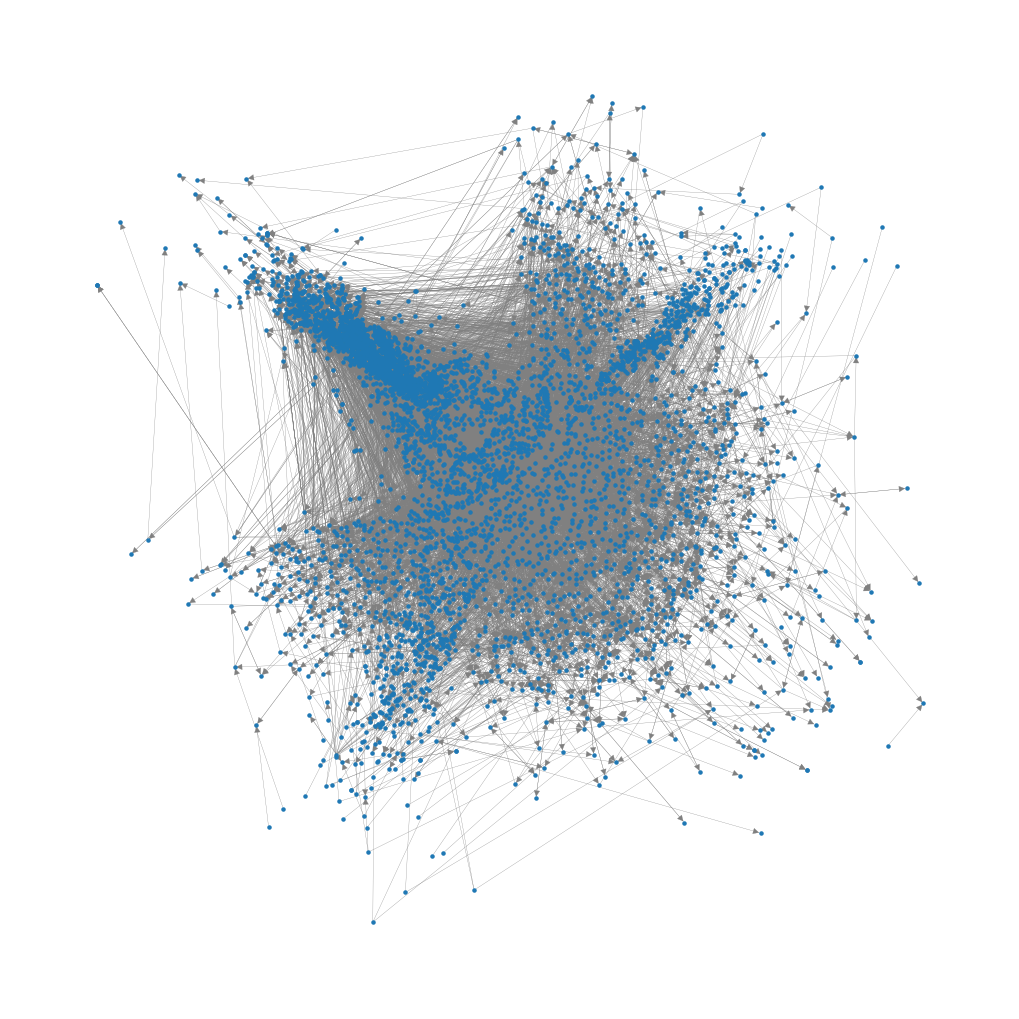

In [ ]:
# Visualize Network
# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

# Generate a layout for the subgraph
pos = nx.kamada_kawai_layout(G)

# Draw the nodes and the edges (tune the size and opacity to make the graph readable)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)

# Hide the axis
plt.axis('off')
# Show the plot
plt.show()

In [ ]:
# Degree distribution histogram
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

# Print degree distribution with the format: degree, count
print("Degree, Count")
for d in np.unique(degree_sequence):
    print(f"Degree: {d}, Count: {degree_sequence.count(d)}")

Degree, Count
Degree: 0, Count: 5951
Degree: 1, Count: 2217
Degree: 2, Count: 1224
Degree: 3, Count: 751
Degree: 4, Count: 479
Degree: 5, Count: 308
Degree: 6, Count: 188
Degree: 7, Count: 143
Degree: 8, Count: 89
Degree: 9, Count: 58
Degree: 10, Count: 56
Degree: 11, Count: 45
Degree: 12, Count: 28
Degree: 13, Count: 27
Degree: 14, Count: 25
Degree: 15, Count: 25
Degree: 16, Count: 20
Degree: 17, Count: 12
Degree: 18, Count: 18
Degree: 19, Count: 8
Degree: 20, Count: 11
Degree: 21, Count: 10
Degree: 22, Count: 5
Degree: 23, Count: 6
Degree: 24, Count: 6
Degree: 25, Count: 6
Degree: 26, Count: 3
Degree: 27, Count: 3
Degree: 28, Count: 8
Degree: 29, Count: 2
Degree: 30, Count: 3
Degree: 31, Count: 2
Degree: 32, Count: 2
Degree: 33, Count: 2
Degree: 34, Count: 2
Degree: 35, Count: 5
Degree: 36, Count: 3
Degree: 37, Count: 1
Degree: 38, Count: 3
Degree: 39, Count: 2
Degree: 40, Count: 1
Degree: 41, Count: 2
Degree: 42, Count: 1
Degree: 44, Count: 3
Degree: 46, Count: 2
Degree: 48, Count: 

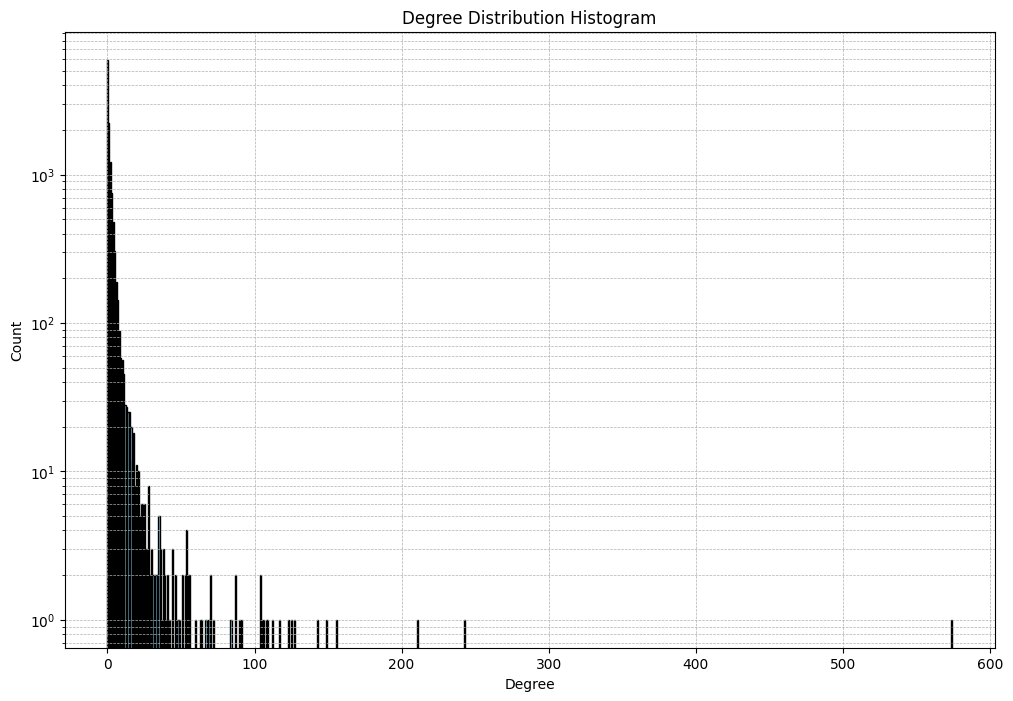

In [ ]:
# Degree distribution data
degrees = np.unique(degree_sequence)
counts = [degree_sequence.count(d) for d in degrees]

# Plotting the degree distribution as a bar plot
plt.figure(figsize=(12, 8))
plt.bar(degrees, counts, width=0.8, color='skyblue', edgecolor='black')

# Since you have a wide range of degrees, you might want to use a log scale
plt.yscale('log')

# Adding labels and title
plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show the plot
plt.show()

In [ ]:
# List of nodes with the highest degree
print("Nodes with the highest degree and their sentiment:")
for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Node {node}: {degree} connections")

Nodes with the highest degree and their sentiment:
Node 104349: 574 connections
Node 2988730: 243 connections
Node 642070: 211 connections
Node 2823755: 156 connections
Node 16343464: 149 connections
Node 51685: 143 connections
Node 126214: 127 connections
Node 1453822: 125 connections
Node 166749: 123 connections
Node 2390182: 117 connections


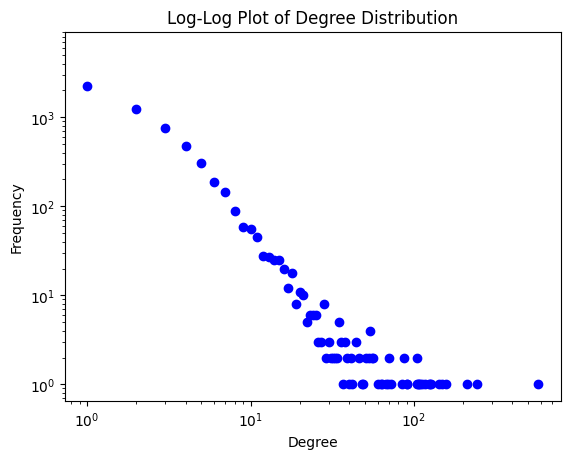

In [ ]:
# Log-Log plot
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.plot(deg, cnt, 'bo')
plt.title("Log-Log Plot of Degree Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

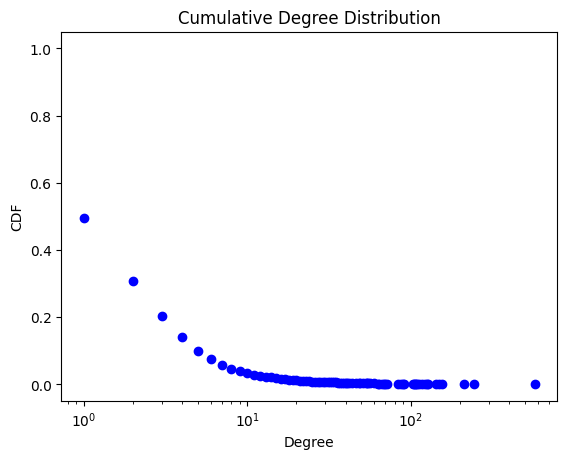

In [ ]:
# Cumulative degree distribution
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

cnt_array = np.array(cnt, dtype=float)
cdf = np.cumsum(cnt_array) / sum(cnt_array)

fig, ax = plt.subplots()
plt.plot(deg, cdf, 'bo')
plt.title("Cumulative Degree Distribution")
plt.ylabel("CDF")
plt.xlabel("Degree")
ax.set_xscale('log')
# ax.set_yscale('log') # Optional: Log scale for the y-axis
plt.show()


In [ ]:
# Degree Centrality
centrality = nx.degree_centrality(G)
# Sort nodes by degree centrality
central_nodes = sorted(centrality, key=centrality.get, reverse=True)

In [ ]:
# Print the 20 nodes with highest degree centrality
print("Nodes with the highest degree centrality and their sentiment:")
count = 1
for node in central_nodes[:20]:
    print(f"{count} Node {node}: {centrality[node]:.4f}")
    count += 1

Nodes with the highest degree centrality and their sentiment:
1 Node 104349: 0.0486
2 Node 2988730: 0.0206
3 Node 642070: 0.0179
4 Node 2823755: 0.0132
5 Node 16343464: 0.0126
6 Node 51685: 0.0121
7 Node 126214: 0.0108
8 Node 1453822: 0.0106
9 Node 166749: 0.0104
10 Node 2390182: 0.0099
11 Node 1322401: 0.0095
12 Node 6622587: 0.0092
13 Node 893: 0.0091
14 Node 6045800: 0.0090
15 Node 4492932: 0.0089
16 Node 84270: 0.0088
17 Node 651174: 0.0088
18 Node 699305: 0.0077
19 Node 5741205: 0.0076
20 Node 4333359: 0.0074


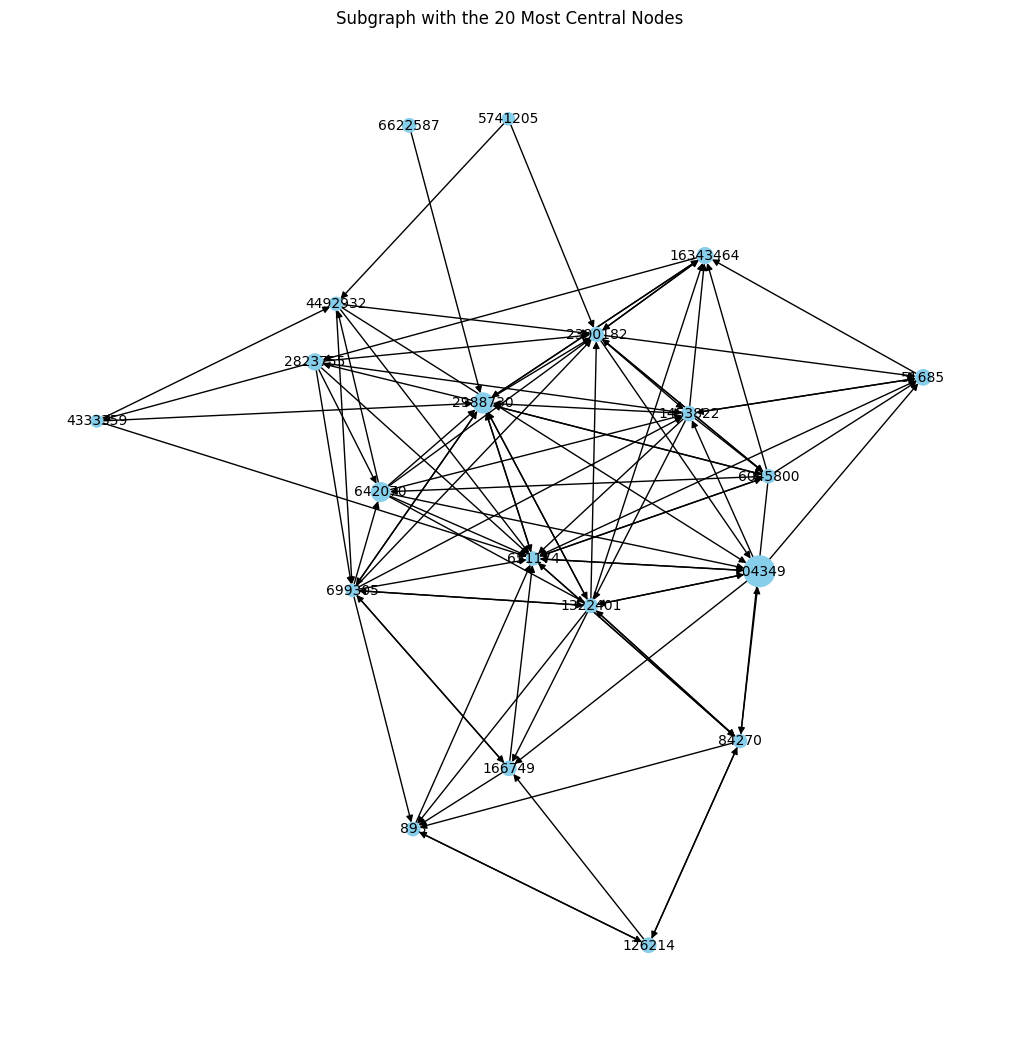

In [ ]:
# Visualize the 20 most central nodes (hubs) and their edges
top_central_nodes = central_nodes[:20]

# Create a subgraph with these nodes
subgraph = G.subgraph(top_central_nodes)

# Use a layout for positioning nodes on the plot
pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=[centrality[n]*10000 for n in subgraph], edge_color='k', linewidths=1, font_size=10)

# Display the plot
plt.title("Subgraph with the 20 Most Central Nodes")
plt.show()


## 5. Subject Matter Experts <a class="anchor" id="sme"></a>

### Prepare data

In [ ]:
posts_mapping = dict(zip(posts['Id'], posts['ViewCount']))
answers_mapping = dict(zip(answers['Id'], answers['ViewCount']))

all_mapping = {**posts_mapping, **answers_mapping}

answers = answers[answers['ParentId'].map(posts_mapping).notna()]
comments = comments[comments['PostId'].map(all_mapping).notna()]

In [ ]:
question_topic_mapping = dict(zip(posts['Id'], posts['Topic']))
answers['Topic'] = answers['ParentId'].map(question_topic_mapping)

answer_topic_mapping = dict(zip(answers['Id'], answers['Topic']))

posts_topic_mapping = {**question_topic_mapping, **answer_topic_mapping} 

comments['Topic'] = comments['PostId'].map(posts_topic_mapping)

### Create new columns

#### Views and ViewCount

In [ ]:
post_probability = 0.5

posts_views_mapping = dict(zip(posts['Id'], posts['ViewCount']*post_probability))
answers['ViewCount'] = answers['ParentId'].map(posts_views_mapping)

In [ ]:
comment_probability = 0.7
posts_views_mapping = dict(zip(posts['Id'], posts['ViewCount']*comment_probability))
answers_views_mapping = dict(zip(answers['Id'], answers['ViewCount']*comment_probability))
comments['Views'] = comments['PostId'].map({**posts_views_mapping, **answers_views_mapping})

#### Main topic

Building a dictionary that links each tag to their corresponding topic.

In [ ]:
def find_topic(tag):
    for i, topic in enumerate(TOPIC_TAGS):
        if tag in topic:
            return i
    return None

# Dictionary TAG -> TOPIC
TAG_TOPICS = {tag: find_topic(tag) for tag in TAG_COUNTS}
print("Tag topics built")

Tag topics built


Get main topic for a post (the topic that we will consider to analyze the post). We follow this criteria:
1. The main topic is the one with the most amount of tags.
2. If there are more than one, the tags with less instances gets picked.

In [ ]:
def get_main_topic(row, verbosity = 0):
    topic_tag_counts = row["Topic"]    
    max_tag = max(topic_tag_counts)
    count_max = sum(1 for el2 in [el == max_tag for el in topic_tag_counts] if el2)
    if verbosity > 0:
        print(f"Max: {max_tag} - Count: {count_max}")
    if count_max == 0:
        return None
    elif count_max == 1:
        return np.argmax(topic_tag_counts)
    else:
        if verbosity > 0:
            print("else")
        # WHICH TAGS ARE IN THE TOPICS THAT ARE DRAWN
        # WE SUM THE NUMBER OF TAG INSTANCES IN EACH TOPIC -> ITERATE OVER TOPIC -> ITERATE OVER TAG -> SUM -> RETURN THE TOPIC WITH THE MINIMUM VALUE
        drawn_topics = [i for (i, tag_count) in enumerate(topic_tag_counts) if tag_count == max_tag]
        topic_tag = {i: [tag for tag in row["Tags"] if tag in TOPIC_TAGS[i]] for i in drawn_topics}
        instance_count = {i: sum([TAG_COUNTS[tag] for tag in topic_tag[i]]) for i in drawn_topics}
        topic = min(instance_count, key=instance_count.get)
        return topic

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Convert the pandas DataFrame to a Dask DataFrame
dask_posts = dd.from_pandas(posts, npartitions=8) # Adjust the number of partitions based on your dataset

# Define a lambda function to be applied to each row
lambda_function = lambda row: get_main_topic(row) 

# Apply the function
# Specify meta as a list, since the function returns a list
dask_posts['MainTopic'] = dask_posts.apply(lambda_function, axis=1, meta=('MainTopic', 'object'))

# Compute the results to get back a pandas DataFrame with a progress bar
with ProgressBar():
    posts = dask_posts.compute()

[########################################] | 100% Completed | 71.25 s


Assign the topic of parent post to the answers.

In [ ]:
question_maintopic_mapping = dict(zip(posts['Id'], posts['MainTopic']))
answers['MainTopic'] = answers['ParentId'].map(question_maintopic_mapping)
print("Answers topic assigned")

Answers topic assigned


Assign the topic of parent post or answer to the comments.

In [ ]:
answer_maintopic_mapping = dict(zip(answers['Id'], answers['MainTopic']))

posts_topic_mapping = {**question_maintopic_mapping, **answer_maintopic_mapping} 

comments['MainTopic'] = comments['PostId'].map(posts_topic_mapping)
print("Comments topic assigned")

Comments topic assigned


#### Scoring

In [ ]:
def get_sentiment(sentiment, i):
    if type(sentiment) == list:
        return sentiment[i]
    else:
        return 0

In [ ]:
WEIGHTS = [0.5, 0.5, 0]

posts_grouped = posts.groupby(['OwnerUserId', 'MainTopic']).agg({'Score': 'sum', 'ViewCount': 'sum', 'Id': 'size'})
answers_grouped = answers.groupby(['OwnerUserId', 'MainTopic']).agg({'Score': 'sum', 'ViewCount': 'sum', 'Id': 'size'})
comments_grouped = comments.groupby(['UserId', 'MainTopic']).agg({'Score': 'sum', 'Views': 'sum', 'Id': 'size'})

In [ ]:
def scoring(topic, weights, row):
    # Retrieve data for the specific user and topic, if available
    userPosts = posts_grouped.loc[(row['Id'], topic)] if (row['Id'], topic) in posts_grouped.index else pd.Series({'Score': 0, 'ViewCount': 1, 'Id': 0})
    userAnswers = answers_grouped.loc[(row['Id'], topic)] if (row['Id'], topic) in answers_grouped.index else pd.Series({'Score': 0, 'ViewCount': 1, 'Id': 0})
    userComments = comments_grouped.loc[(row['Id'], topic)] if (row['Id'], topic) in comments_grouped.index else pd.Series({'Score': 0, 'Views': 1, 'Id': 0})
    
    # Calculate the score
    score = userAnswers['Id'] * (get_sentiment(row["AvgTopicSentiment"], topic) + 20 * userAnswers['Score'] / userAnswers['ViewCount']) * weights[0] +\
            userComments['Id'] * min(userComments['Score'] / userComments['Views'], 1) * weights[1] +\
            min(userPosts['Score'] / userPosts['ViewCount'], 1) * weights[2]

    return score

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
def use_dask(df, method, npartitions = 8):
    # Convert the pandas DataFrame to a Dask DataFrame
    dask_df = dd.from_pandas(df, npartitions=npartitions) # Adjust the number of partitions based on your dataset

    method(dask_df)
    
    # Compute the results to get back a pandas DataFrame with a progress bar
    with ProgressBar():
        temp = dask_df.compute()
    return temp

In [ ]:
def calculate_score(dask_df):
    # Define a lambda function to be applied to each row
    lambda_function = lambda row: [scoring(i, WEIGHTS, row) for i, _ in enumerate(TOPIC_TAGS)]

    # Apply the function
    # Specify meta as a list, since the function returns a list
    dask_df['Score'] = dask_df.apply(lambda_function, axis=1, meta=('Score', 'object'))

In [ ]:
use_dask(USERS, calculate_score)

[########################################] | 100% Completed | 273.59 s


,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,PostCount,CommentCount,AcceptedAnswerCount,...,Score_5,Score_6,Score_7,Score_8,Score_9,Score_10,Score_11,Score_12,Score_13,Score_14
0,6128789,462,2016-03-29 10:49:52.617,2023-08-29 00:00:10.917,56,15,1,31.0,32.0,0.0,...,0.000000,0.0,0.000000,0.021808,0.0,0.0,0.0,0.0,0.0,0.0
1,580346,22895,2011-01-18 17:59:01.030,2023-08-31 10:24:31.333,1122,4919,82,0.0,778.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,794606,1872,2011-06-12 08:51:06.137,2023-03-28 16:43:29.407,1171,208,432,1.0,1879.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,10637188,742,2018-11-11 18:15:38.430,2023-08-29 19:28:34.423,133,115,2,20.0,126.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1000626,6197,2011-10-18 07:44:34.317,2023-08-24 13:53:59.520,649,468,24,5.0,379.0,0.0,...,0.000000,0.0,0.012107,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11805,3135460,5277,2013-12-26 00:51:44.440,2023-06-19 02:46:05.680,409,171,14,38.0,411.0,0.0,...,0.000737,0.0,0.000040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11806,2616735,1382,2013-07-25 01:00:55.527,2023-09-03 03:50:34.047,140,602,278,0.0,78.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11807,209863,1189,2009-11-12 18:59:14.360,2015-07-18 14:59:21.783,185,58,0,12.0,72.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11808,3750282,448,2014-06-17 21:45:20.047,2023-06-02 11:14:19.157,75,9,1,3.0,52.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def create_score_columns(dask_df):
    for i in range(len(TOPIC_TAGS)):
        dask_df[f'Score_{i}'] = dask_df.apply(lambda row: row['Score'][i], axis=1)

In [ ]:
create_score_columns(USERS)

### Results

In [ ]:
def count_posts_expert_participated(experts):
    exp_comments = comments[comments['UserId'].isin(experts)]["PostId"]
    exp_answers = answers[answers['OwnerUserId'].isin(experts) | answers['Id'].isin(exp_comments)]["ParentId"]
    exp_posts = posts[posts['OwnerUserId'].isin(experts) | posts['Id'].isin(exp_answers) | posts['Id'].isin(exp_comments)]["ParentId"]
    return len(exp_posts)

In [ ]:
import math
def define_experts(top = 10):
    ordered_users_by_topic = dict()
    threshold = dict()
    active_users_by_topic = dict()
    expert_candidates = dict()
    for i in range(len(TOPIC_TAGS)):
        ordered_users_by_topic[i] = USERS.sort_values(by=f"Score_{i}", ascending=False)[['Id', f"Score_{i}"]]
        active_users_by_topic[i] = ordered_users_by_topic[i][ordered_users_by_topic[i][f"Score_{i}"] > 0]
        if(len(active_users_by_topic[i]) > 0):
            threshold[i] = np.percentile(active_users_by_topic[i][f"Score_{i}"], q=(100 - top))
        else:
            threshold[i] = math.inf
        expert_candidates[i] = list(active_users_by_topic[i][active_users_by_topic[i][f"Score_{i}"] > threshold[i]]["Id"])

    flatten_experts = list(pd.Series([el for i in expert_candidates for el in expert_candidates[i] ]).unique())

    return expert_candidates, round(100*count_posts_expert_participated(flatten_experts)/count_posts_expert_participated(USERS["Id"]))

In [ ]:
top_possible_values = [0,0.1, 1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
values = []
for top in top_possible_values:
    (_, perc) = define_experts(top)
    values += [perc]

C:\Users\PC-312\AppData\Local\Temp\ipykernel_14532\2224616765.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flatten_experts = list(pd.Series([el for i in expert_candidates for el in expert_candidates[i] ]).unique())


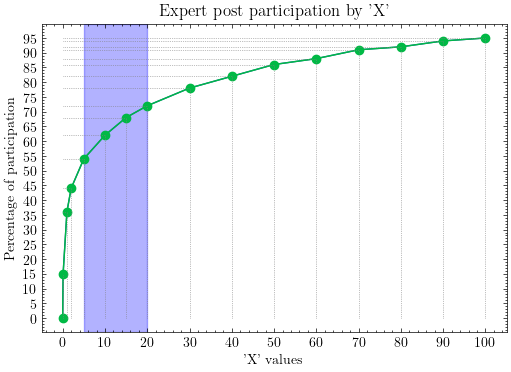

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
# Creating the plot
with plt.style.context('science'):
    plt.figure(figsize=(6,4))
    plt.plot(top_possible_values, values)  # Plot x vs y
    
    x = top_possible_values
    y = values

    # Creating the plot
    plt.plot(x, y, marker='o')  # Adding markers for each point

    # Adding horizontal lines from each y-point to the x-axis
    for x_val, y_val in zip(x, y):
        plt.hlines(y_val, xmin=0, xmax=x_val, linestyles='dotted', colors='grey', linewidth = 0.5)

    # Adding vertical lines from each x-point to the y-axis
    for x_val, y_val in zip(x, y):
        plt.vlines(x_val, ymin=0, ymax=y_val, linestyles='dotted', colors='grey', linewidth = 0.5)

    # Adjusting x-ticks
    x_tick_interval = 10  # Adjust this value as needed for optimal spacing
    x_ticks = np.arange(np.min(x), np.max(x) + x_tick_interval, x_tick_interval)
    plt.xticks(x_ticks)
    # Adjusting y-ticks
    y_tick_interval = 5  # Adjust this value as needed for optimal spacing
    y_ticks = np.arange(np.min(y), np.max(y) + y_tick_interval, y_tick_interval)
    plt.yticks(y_ticks)

    # Adding a transparent rectangle
    plt.axvspan(5, 20, color='blue', alpha=0.3)  # Span from x=5 to x=10


    # Adding title and labels
    plt.title("Expert post participation by 'X'")
    plt.xlabel("'X' values")
    plt.ylabel("Percentage of participation")

    # Displaying the plot
    plt.show()